# Portfolio Stress Testing: COVID-19 Scenarios

This notebook is a guide to understanding market risk during crisis events

Portfolio stress testing is a risk management technique that evaluates how a portfolio would perform under extreme market conditions. Instead of relying solely on historical volatility or normal market conditions, stress testing applies hypothetical or historical "shocks" to see how investments would fare during crisis events.

Importance:
- Risk Assessment: Understand potential losses during market downturns
- Position Sizing: Determine appropriate allocation sizes based on risk tolerance
- Scenario Planning: Prepare for various market conditions
- Regulatory Compliance: Many institutions are required to conduct stress tests

## Case study: COVID-19
The COVID-19 pandemic created one of the fastest market crashes in history, followed by an unprecedented recovery. This makes it an excellent case study for understanding.

Let's start importing the required packages:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from datetime import datetime
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [2]:
project_root = os.path.abspath("..")  # or two levels up if needed
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [3]:
from risk_management.stress_test import PortfolioStressTester, create_market_crash_scenario

### Portfolio Construction
Let's create a diversified portfolio that represents a typical investor's holdings during early 2020, with Feb prices

In [4]:
portfolio = PortfolioStressTester("Diversified Growth Portfolio")

In [5]:
positions = [
    # Core Holdings
    ('SPY', 100, 337.0, 'ETF'),      # S&P 500 ETF
    ('QQQ', 50, 237.0, 'ETF'),       # Nasdaq ETF
    
    # Individual Stocks
    ('AAPL', 100, 327.0, 'Equity'),  # Apple
    ('MSFT', 50, 190.0, 'Equity'),   # Microsoft
    ('TSLA', 25, 917.0, 'Equity'),   # Tesla
    
    # Sector ETFs
    ('XLF', 200, 31.0, 'ETF'),       # Financials
    ('XLE', 100, 45.0, 'ETF'),       # Energy
    
    # Defensive Assets
    ('GLD', 50, 154.0, 'Commodity'), # Gold ETF
    ('TLT', 30, 146.0, 'Bond'),      # Long-term Treasuries
]

In [6]:
# Add all positions
for asset, qty, price, asset_class in positions:
    portfolio.add_position(asset, qty, price, asset_class)

# Display portfolio summary
portfolio_df = portfolio.get_portfolio_summary()
print(f"Portfolio Summary ({len(positions)} positions):")
# print(portfolio_df.round(2))
print(portfolio_df.to_string(index=False, float_format='%.2f'))


total_value = portfolio_df['Market Value'].sum()
print(f"\n Total Portfolio Value: ${total_value:,.2f}")

# Show asset class allocation
asset_class_allocation = portfolio_df.groupby('Asset Class')['Weight %'].sum().sort_values(ascending=False)
print(f"\n ASSET CLASS ALLOCATION:")
for asset_class, weight in asset_class_allocation.items():
    print(f"   {asset_class}: {weight:.1f}%")

Portfolio Summary (9 positions):
Asset  Quantity  Price  Market Value  Weight % Asset Class Currency
  SPY       100 337.00      33700.00     25.25         ETF      USD
  QQQ        50 237.00      11850.00      8.88         ETF      USD
 AAPL       100 327.00      32700.00     24.50      Equity      USD
 MSFT        50 190.00       9500.00      7.12      Equity      USD
 TSLA        25 917.00      22925.00     17.18      Equity      USD
  XLF       200  31.00       6200.00      4.65         ETF      USD
  XLE       100  45.00       4500.00      3.37         ETF      USD
  GLD        50 154.00       7700.00      5.77   Commodity      USD
  TLT        30 146.00       4380.00      3.28        Bond      USD

 Total Portfolio Value: $133,455.00

 ASSET CLASS ALLOCATION:
   Equity: 48.8%
   ETF: 42.1%
   Commodity: 5.8%
   Bond: 3.3%


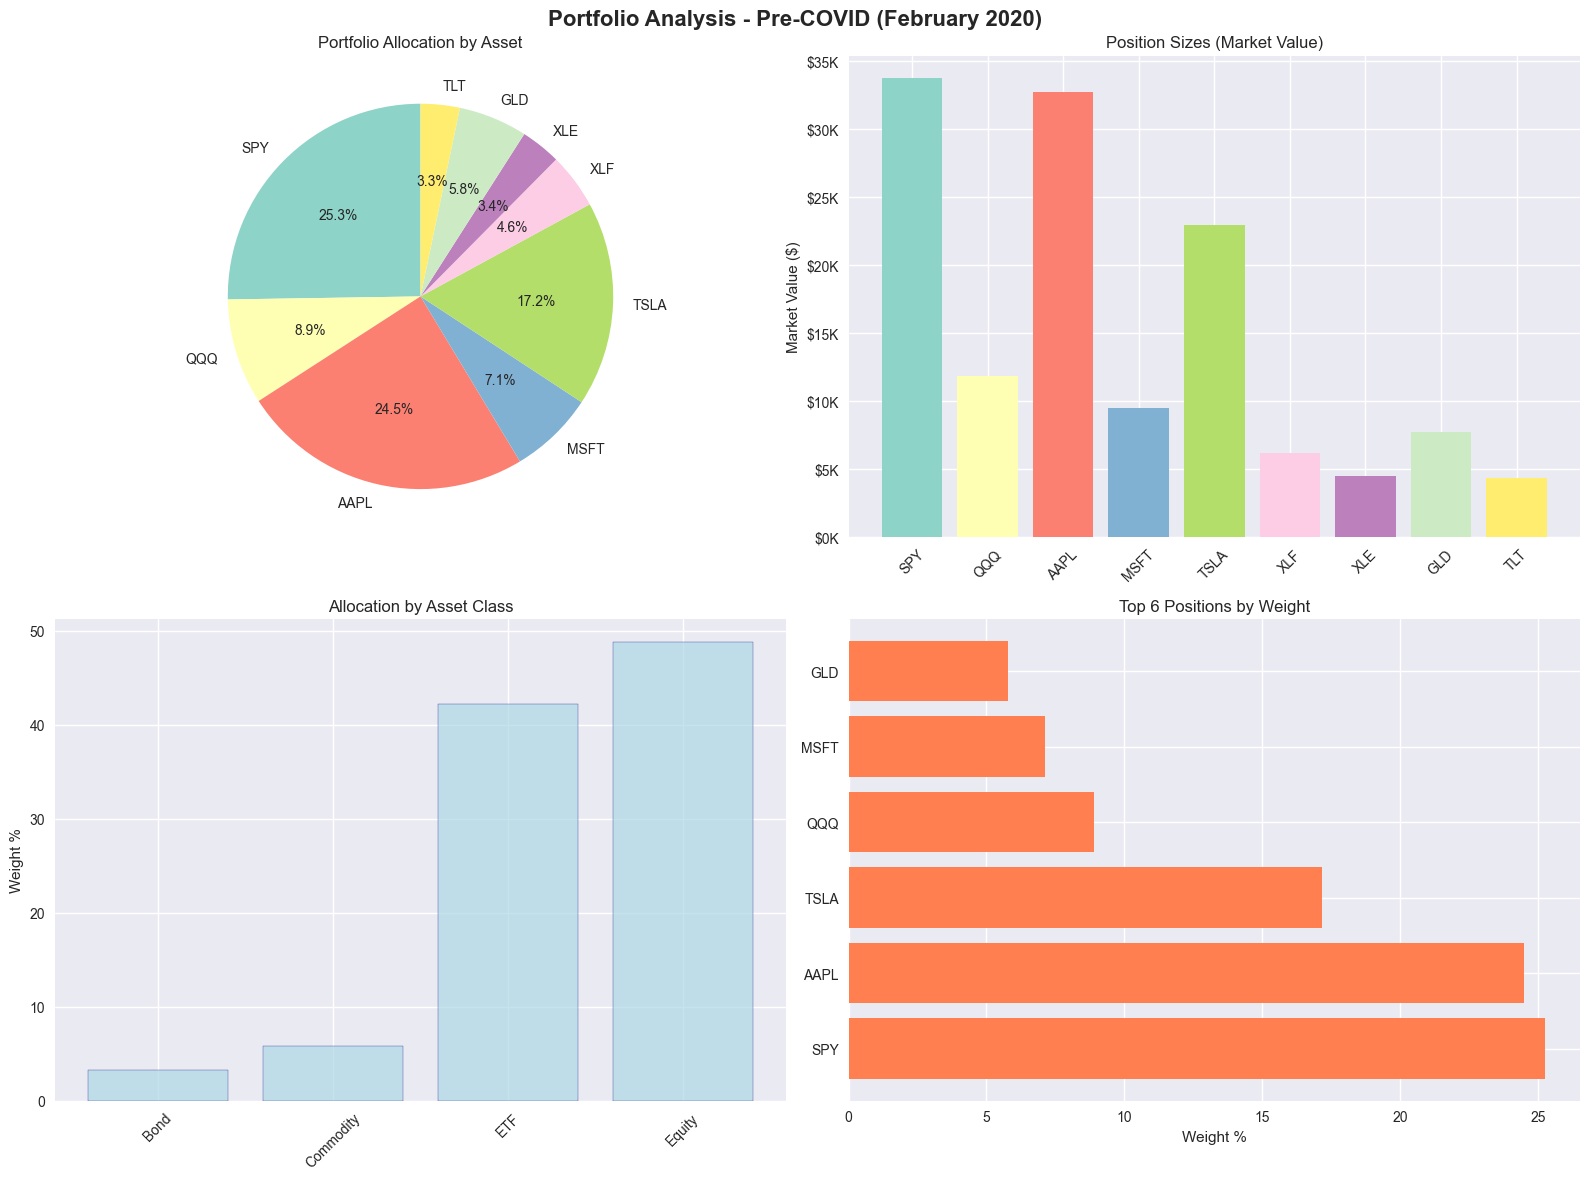


 PORTFOLIO STATISTICS:
• Number of positions: 9
• Largest position: SPY (25.3%)
• Asset class diversity: 4 classes
• Equity allocation: 90.9%
• Defensive allocation: 9.1%


In [7]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Portfolio Analysis - Pre-COVID (February 2020)', fontsize=16, fontweight='bold')

# 1. Portfolio weights (pie chart)
colors = plt.cm.Set3(np.linspace(0, 1, len(portfolio_df)))
wedges, texts, autotexts = ax1.pie(portfolio_df['Weight %'], 
                                   labels=portfolio_df['Asset'],
                                   autopct='%1.1f%%', 
                                   colors=colors, 
                                   startangle=90)
ax1.set_title('Portfolio Allocation by Asset')

# 2. Position sizes (bar chart)
ax2.bar(portfolio_df['Asset'], portfolio_df['Market Value'], color=colors)
ax2.set_title('Position Sizes (Market Value)')
ax2.set_ylabel('Market Value ($)')
ax2.tick_params(axis='x', rotation=45)
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))

# 3. Asset class allocation
asset_class_weights = portfolio_df.groupby('Asset Class')['Weight %'].sum()
ax3.bar(asset_class_weights.index, asset_class_weights.values, 
        color='lightblue', edgecolor='navy', alpha=0.7)
ax3.set_title('Allocation by Asset Class')
ax3.set_ylabel('Weight %')
ax3.tick_params(axis='x', rotation=45)

# 4. Risk concentration (largest positions)
top_positions = portfolio_df.nlargest(6, 'Weight %')
ax4.barh(top_positions['Asset'], top_positions['Weight %'], color='coral')
ax4.set_title('Top 6 Positions by Weight')
ax4.set_xlabel('Weight %')

plt.tight_layout()
plt.show()

# Portfolio statistics
print(f"\n PORTFOLIO STATISTICS:")
print(f"• Number of positions: {len(portfolio_df)}")
print(f"• Largest position: {portfolio_df.loc[portfolio_df['Weight %'].idxmax(), 'Asset']} ({portfolio_df['Weight %'].max():.1f}%)")
print(f"• Asset class diversity: {portfolio_df['Asset Class'].nunique()} classes")
print(f"• Equity allocation: {portfolio_df[portfolio_df['Asset Class'].isin(['Equity', 'ETF'])]['Weight %'].sum():.1f}%")
print(f"• Defensive allocation: {portfolio_df[portfolio_df['Asset Class'].isin(['Bond', 'Commodity'])]['Weight %'].sum():.1f}%")


### Understanding COVID-19 Market Scenarios
Before running our stress tests, let's understand what happened during COVID-19:
Timeline of Events:
- Initial Crash (Feb 19 - Mar 23, 2020): Fastest bear market in history
- Recovery Rally (Mar 23 - Aug 2020): Massive stimulus-driven recovery
- Vaccine Rotation (Nov 2020): Shift from growth to value stocks

In [8]:
# Load COVID scenarios from our framework
portfolio.create_covid_scenarios()

# Add some additional hypothetical scenarios using utility functions
portfolio.add_scenario('Generic Market Crash', create_market_crash_scenario(), 
                      'Hypothetical broad market crash scenario')

# Add a custom scenario
portfolio.add_scenario('Tech Bubble Burst 2.0', {
    'QQQ': -0.45, 'AAPL': -0.40, 'MSFT': -0.35, 'TSLA': -0.60,
    'SPY': -0.25, 'XLF': -0.15, 'GLD': +0.08, 'TLT': +0.12
}, 'Hypothetical tech sector collapse')

print("✅ Scenarios loaded successfully!")
print(f"Available scenarios: {len(portfolio.stress_scenarios)}")
for name in portfolio.stress_scenarios.keys():
    print(f"  • {name}")


✅ Scenarios loaded successfully!
Available scenarios: 5
  • COVID Initial Crash
  • COVID Recovery Rally
  • COVID Vaccine Rotation
  • Generic Market Crash
  • Tech Bubble Burst 2.0


## Running the Stress Tests
Now let's run our stress tests and see how our portfolio would have performed:

In [9]:
results_df = portfolio.run_all_scenarios()
print("Stress Test Results Summary:")
print(results_df[['Scenario', 'Type', 'Total P&L', 'P&L %']].round(2))

# Identify best and worst scenarios
best_scenario = results_df.loc[results_df['P&L %'].idxmax(), 'Scenario']
worst_scenario = results_df.loc[results_df['P&L %'].idxmin(), 'Scenario']

print(f"\n KEY RESULTS:")
print(f"• Best scenario: {best_scenario} ({results_df.loc[results_df['Scenario'] == best_scenario, 'P&L %'].iloc[0]:+.1f}%)")
print(f"• Worst scenario: {worst_scenario} ({results_df.loc[results_df['Scenario'] == worst_scenario, 'P&L %'].iloc[0]:+.1f}%)")


Stress Test Results Summary:
                 Scenario          Type  Total P&L  P&L %
0     COVID Initial Crash    historical  -45652.20 -34.21
1    COVID Recovery Rally    historical  112579.00  84.36
2  COVID Vaccine Rotation    historical    6931.35   5.19
3    Generic Market Crash  hypothetical  -10553.00  -7.91
4   Tech Bubble Burst 2.0  hypothetical  -43705.90 -32.75

 KEY RESULTS:
• Best scenario: COVID Recovery Rally (+84.4%)
• Worst scenario: COVID Initial Crash (-34.2%)


### Detailed Analysis of COVID crash

In [10]:
# Get position-level analysis
crash_analysis = portfolio.get_position_analysis('COVID Initial Crash')
crash_analysis_sorted = crash_analysis.sort_values('Position P&L')

print("Position-level P&L during COVID crash:")
print(crash_analysis_sorted[['Asset', 'Shock %', 'Position P&L', 'Contribution to Total P&L %']].round(2))

# Benchmark comparison
benchmark_comparison = portfolio.compare_to_benchmark('COVID Initial Crash', 'SPY')
print(f"\n📊 BENCHMARK COMPARISON:")
print(f"• Portfolio return: {benchmark_comparison['portfolio_return']:+.2f}%")
print(f"• S&P 500 return: {benchmark_comparison['benchmark_return']:+.2f}%")
print(f"• Outperformance: {benchmark_comparison['outperformance']:+.2f}%")

if benchmark_comparison['outperformance'] > 0:
    print("✅ Portfolio outperformed the market!")
else:
    print("❌ Portfolio underperformed the market.")

Position-level P&L during COVID crash:
  Asset  Shock %  Position P&L  Contribution to Total P&L %
4  TSLA    -60.0      -13755.0                        30.13
0   SPY    -34.0      -11458.0                        25.10
2  AAPL    -31.0      -10137.0                        22.20
1   QQQ    -30.0       -3555.0                         7.79
5   XLF    -45.0       -2790.0                         6.11
3  MSFT    -29.0       -2755.0                         6.03
6   XLE    -54.0       -2430.0                         5.32
7   GLD      4.0         308.0                        -0.67
8   TLT     21.0         919.8                        -2.01

📊 BENCHMARK COMPARISON:
• Portfolio return: -34.21%
• S&P 500 return: -34.00%
• Outperformance: -0.21%
❌ Portfolio underperformed the market.


#### Performance dashboard

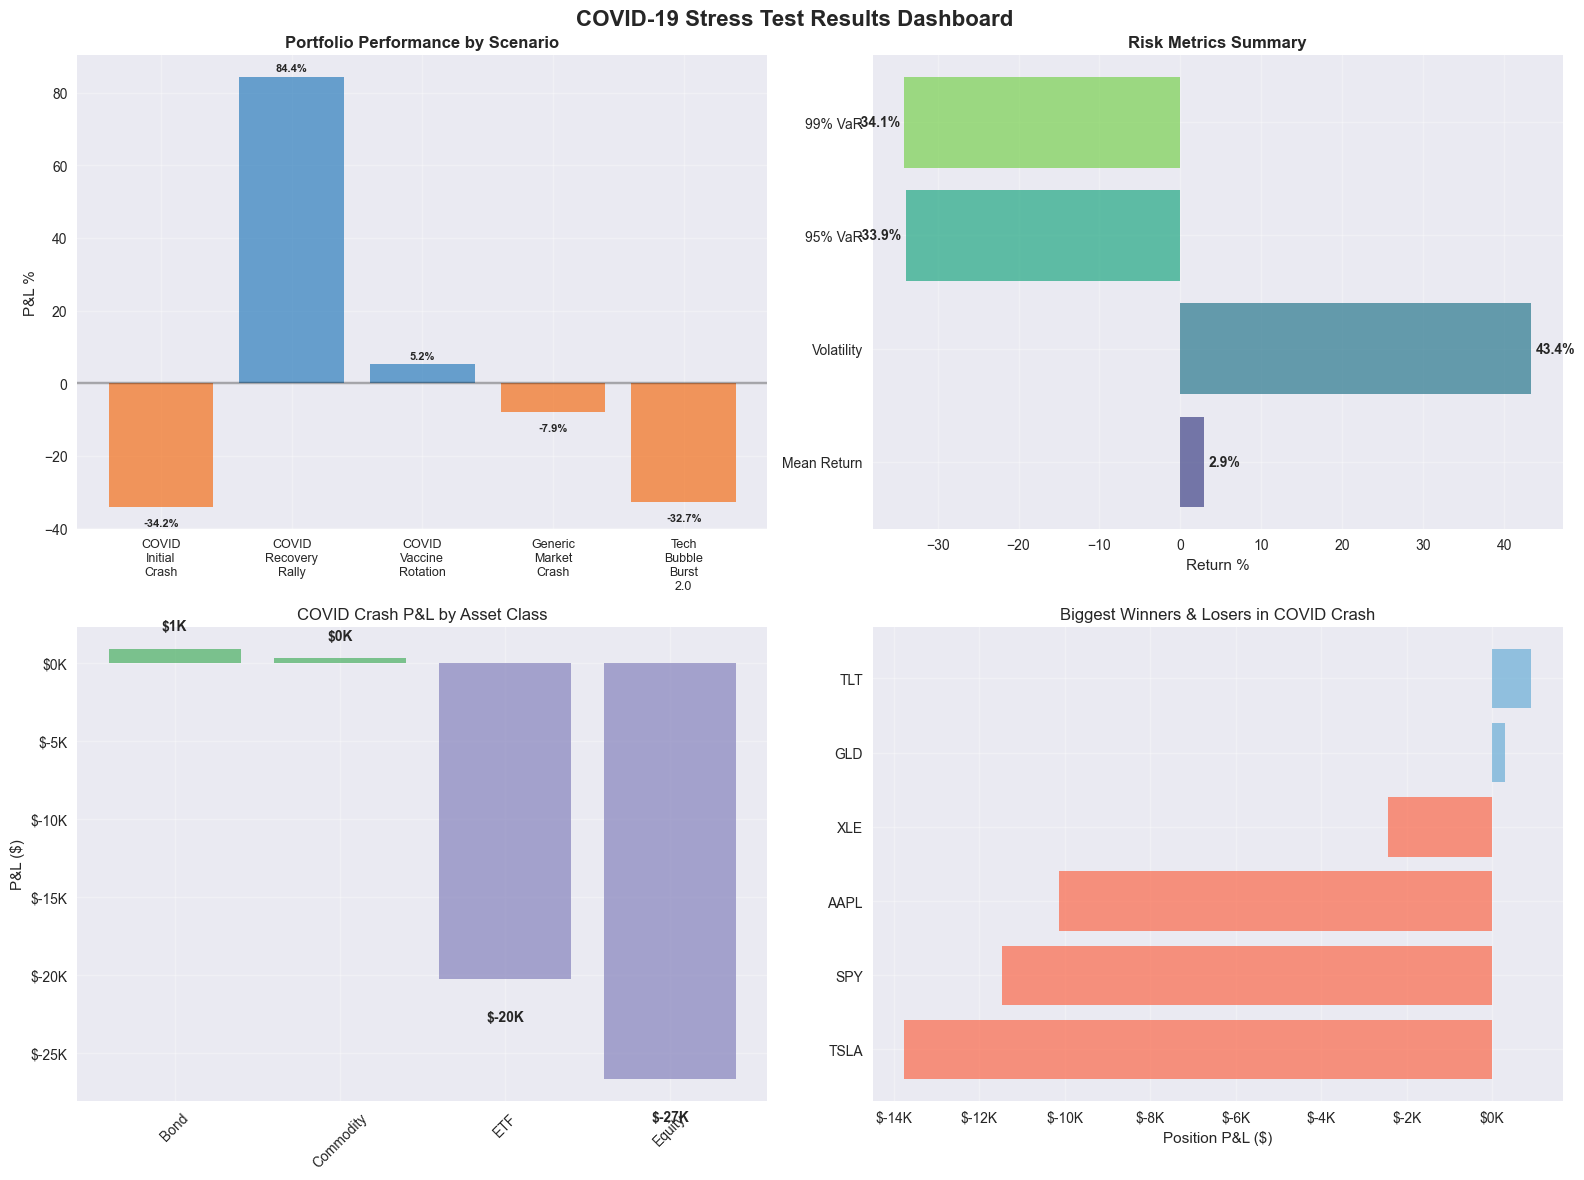

In [11]:
# FIGURE 1: Main Performance Dashboard (2x2 layout)
fig1, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
fig1.suptitle('COVID-19 Stress Test Results Dashboard', fontsize=16, fontweight='bold')

# 1. Scenario P&L comparison
colors_pnl = [plt.cm.Oranges(0.6) if x < 0 else plt.cm.Blues(0.7) for x in results_df['P&L %']]
bars = ax1.bar(range(len(results_df)), results_df['P&L %'], color=colors_pnl, alpha=0.7)
ax1.set_title('Portfolio Performance by Scenario', fontsize=12, fontweight='bold')
ax1.set_ylabel('P&L %')
ax1.set_xticks(range(len(results_df)))
ax1.set_xticklabels([s.replace(' ', '\n') for s in results_df['Scenario']], rotation=0, ha='center', fontsize=9)
ax1.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax1.grid(True, alpha=0.3)

# Add value labels
for bar, value in zip(bars, results_df['P&L %']):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + (1 if height > 0 else -3),
             f'{value:.1f}%', ha='center', va='bottom' if height > 0 else 'top',
             fontweight='bold', fontsize=8)

# 2. Risk metrics
risk_metrics = portfolio.get_risk_metrics()
metrics_to_show = ['Mean Return', 'Volatility', '95% VaR', '99% VaR']
metric_values = [risk_metrics['mean_return'], risk_metrics['volatility'], 
                 risk_metrics['var_95'], risk_metrics['var_99']]
colors_risk = plt.cm.viridis(np.linspace(0.2, 0.8, len(metrics_to_show)))
bars2 = ax2.barh(metrics_to_show, metric_values, color=colors_risk, alpha=0.7)
ax2.set_title('Risk Metrics Summary', fontweight='bold')
ax2.set_xlabel('Return %')
ax2.grid(True, alpha=0.3)

# Add value labels for risk metrics
for bar, value in zip(bars2, metric_values):
    width = bar.get_width()
    ax2.text(width + (0.5 if width > 0 else -0.5), bar.get_y() + bar.get_height()/2.,
             f'{value:.1f}%', ha='left' if width > 0 else 'right', va='center', fontweight='bold')

# 3. Asset class performance in COVID crash
crash_by_class = crash_analysis.groupby('Asset Class')['Position P&L'].sum()
colors_class = [plt.cm.Purples(0.6) if x < 0 else plt.cm.Greens(0.6) for x in crash_by_class.values]
bars3 = ax3.bar(crash_by_class.index, crash_by_class.values, color=colors_class, alpha=0.7)
ax3.set_title('COVID Crash P&L by Asset Class')
ax3.set_ylabel('P&L ($)')
ax3.tick_params(axis='x', rotation=45)
ax3.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))
ax3.grid(True, alpha=0.3)

# Add value labels for asset classes
for bar, value in zip(bars3, crash_by_class.values):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + (1000 if height > 0 else -2000),
             f'${value/1000:.0f}K', ha='center', va='bottom' if height > 0 else 'top', fontweight='bold')

# 4. Position contribution analysis (top 6 for readability) - FIXED WITH PASTEL COLORS
# Fixed: Using pd.concat instead of deprecated append()
worst_3 = crash_analysis.sort_values('Position P&L').head(3)
best_3 = crash_analysis.sort_values('Position P&L').tail(3)
crash_contributions = pd.concat([worst_3, best_3])  # Worst 3 + Best 3

# Changed to use pastel colors consistent with other plots
colors_contrib = [plt.cm.Reds(0.5) if x < 0 else plt.cm.Blues(0.5) for x in crash_contributions['Position P&L']]
bars4 = ax4.barh(crash_contributions['Asset'], crash_contributions['Position P&L'], color=colors_contrib, alpha=0.7)
ax4.set_title('Biggest Winners & Losers in COVID Crash')
ax4.set_xlabel('Position P&L ($)')
ax4.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

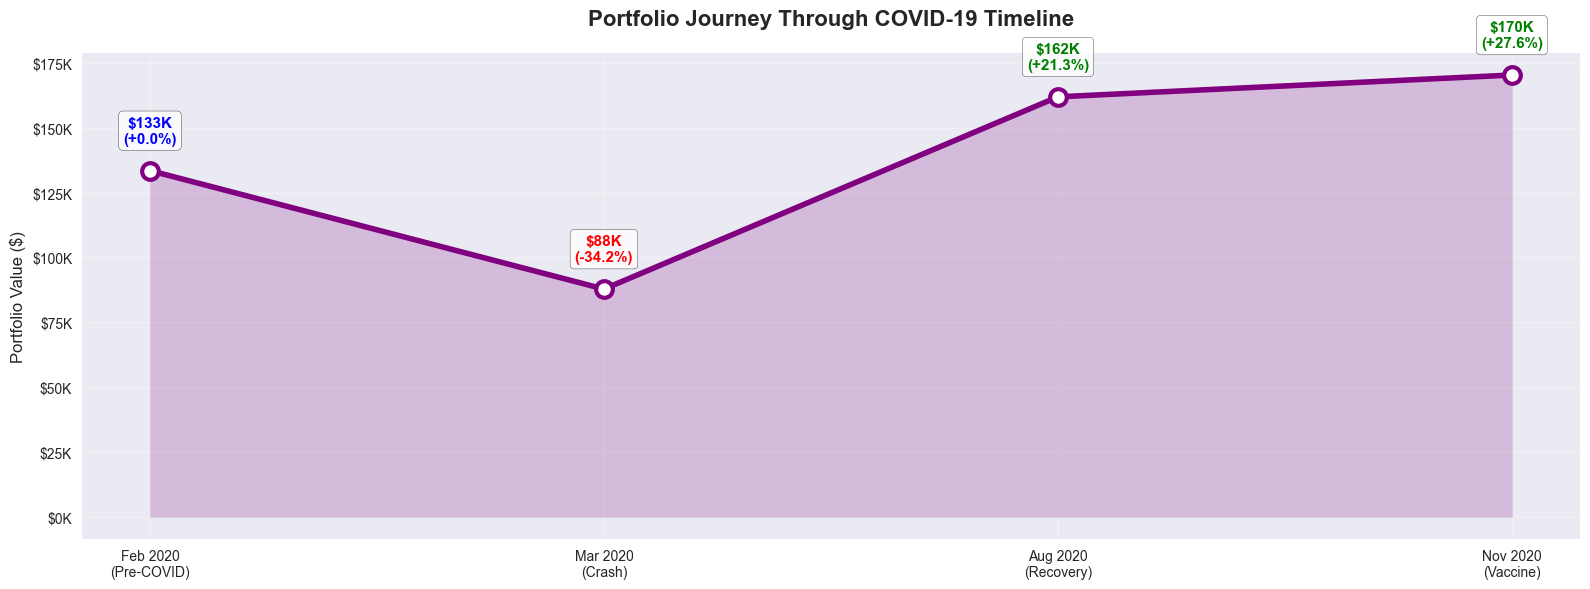

In [12]:
fig2, ax_timeline = plt.subplots(1, 1, figsize=(16, 6))
covid_scenarios = ['COVID Initial Crash', 'COVID Recovery Rally', 'COVID Vaccine Rotation']
covid_results = [portfolio.results[s]['total_return_pct'] for s in covid_scenarios]
portfolio_values = [total_value]
current_value = total_value

for ret in covid_results:
    current_value = current_value * (1 + ret/100)
    portfolio_values.append(current_value)

# Create timeline with enhanced styling
dates = ['Feb 2020\n(Pre-COVID)', 'Mar 2020\n(Crash)', 'Aug 2020\n(Recovery)', 'Nov 2020\n(Vaccine)']
ax_timeline.plot(dates, portfolio_values, 'o-', linewidth=4, markersize=12, color='purple', markerfacecolor='white', markeredgewidth=3)
ax_timeline.fill_between(dates, portfolio_values, alpha=0.2, color='purple')
ax_timeline.set_title('Portfolio Journey Through COVID-19 Timeline', fontsize=16, fontweight='bold', pad=20)
ax_timeline.set_ylabel('Portfolio Value ($)', fontsize=12)
ax_timeline.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))
ax_timeline.grid(True, alpha=0.3)

# Add enhanced value labels
for i, val in enumerate(portfolio_values):
    change = ((val - total_value) / total_value) * 100 if i > 0 else 0
    color = 'red' if change < 0 else ('green' if change > 0 else 'blue')
    ax_timeline.annotate(f'${val/1000:.0f}K\n({change:+.1f}%)', 
                (i, val), textcoords="offset points", xytext=(0,20), ha='center', 
                fontweight='bold', fontsize=11, color=color,
                bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

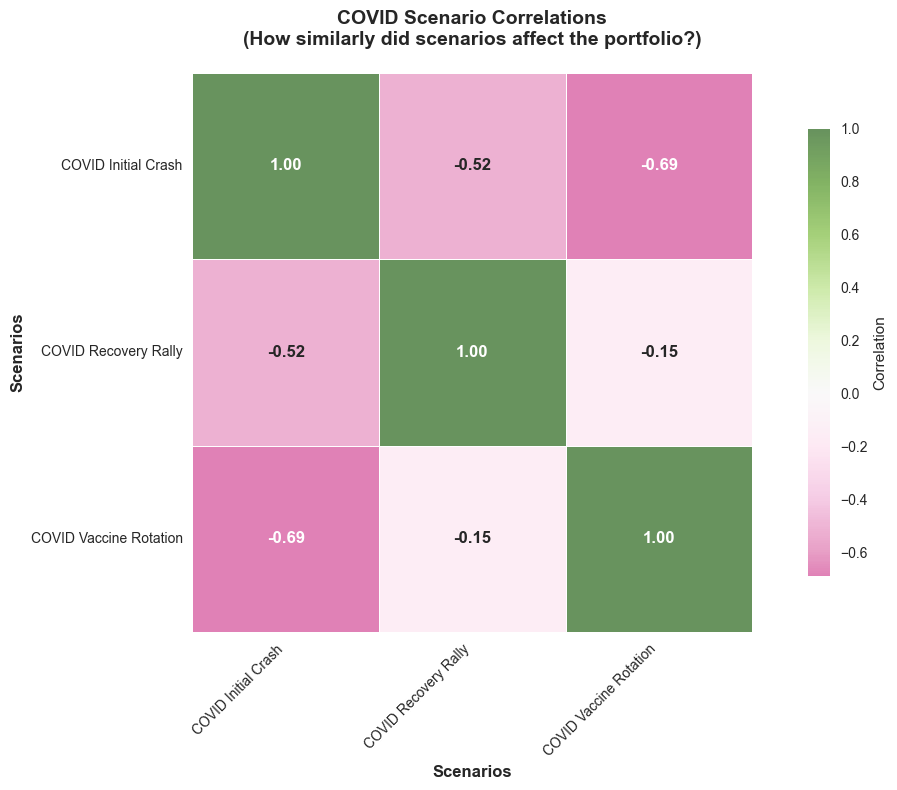

In [13]:
if len(covid_scenarios) >= 2:
    fig3, ax_corr = plt.subplots(1, 1, figsize=(12, 8))
    
    # Create a correlation matrix of scenario returns for each asset
    scenario_returns = {}
    for scenario in covid_scenarios:
        pos_analysis = portfolio.get_position_analysis(scenario)
        scenario_returns[scenario] = pos_analysis.set_index('Asset')['Shock %']
    corr_df = pd.DataFrame(scenario_returns).fillna(0)
    corr_matrix = corr_df.corr()
    
    # Plot enhanced heatmap with appealing colors
    # Create a custom pastel version of PiYG
    import matplotlib.colors as mcolors
    
    # Get the PiYG colormap and make it more pastel
    cmap = plt.cm.PiYG
    colors = cmap(np.linspace(0, 1, 256))
    # Lighten the colors by blending with white
    pastel_colors = colors * 0.7 + np.array([1, 1, 1, 1]) * 0.3
    pastel_cmap = mcolors.ListedColormap(pastel_colors)
    
    sns.heatmap(corr_matrix, annot=True, cmap=pastel_cmap, center=0, 
               square=True, ax=ax_corr, cbar_kws={'shrink': 0.8, 'label': 'Correlation'},
               fmt='.2f', annot_kws={'fontsize': 12, 'fontweight': 'bold'},
               linewidths=0.5, linecolor='white')
    
    ax_corr.set_title('COVID Scenario Correlations\n(How similarly did scenarios affect the portfolio?)', 
                     fontsize=14, fontweight='bold', pad=20)
    ax_corr.set_xlabel('Scenarios', fontsize=12, fontweight='bold')
    ax_corr.set_ylabel('Scenarios', fontsize=12, fontweight='bold')
    
    # Rotate labels for better readability
    ax_corr.set_xticklabels(ax_corr.get_xticklabels(), rotation=45, ha='right')
    ax_corr.set_yticklabels(ax_corr.get_yticklabels(), rotation=0)
    
    plt.tight_layout()
    plt.show()

#### Risk Metrics

In [18]:
# Value at Risk calculation
risk_metrics = portfolio.get_risk_metrics()
print(f"95% Value at Risk (VaR): {risk_metrics['var_95']:.2f}%")
print("  → This means: 95% of the time, losses won't exceed this amount")
print(f"99% Value at Risk (VaR): {risk_metrics['var_99']:.2f}%")
print("  → This means: 99% of the time, losses won't exceed this amount")
print(f"Maximum Loss Scenario: {risk_metrics['min_return']:.2f}%")
print("  → Worst-case scenario among all tested")

# Diversification analysis
print(f"\n DIVERSIFICATION ANALYSIS:")
print("-" * 35)

# Calculate asset class correlations during stress
covid_crash_data = crash_analysis.set_index('Asset')['Shock %']
print("Asset Class Performance During COVID Crash:")
class_performance = crash_analysis.groupby('Asset Class').agg({
    'Shock %': 'mean',
    'Position P&L': 'sum',
    'Portfolio Weight %': 'sum'
}).round(2)
print(class_performance)


95% Value at Risk (VaR): -33.92%
  → This means: 95% of the time, losses won't exceed this amount
99% Value at Risk (VaR): -34.15%
  → This means: 99% of the time, losses won't exceed this amount
Maximum Loss Scenario: -34.21%
  → Worst-case scenario among all tested

 DIVERSIFICATION ANALYSIS:
-----------------------------------
Asset Class Performance During COVID Crash:
             Shock %  Position P&L  Portfolio Weight %
Asset Class                                           
Bond           21.00         919.8                3.28
Commodity       4.00         308.0                5.77
ETF           -40.75      -20233.0               42.15
Equity        -40.00      -26647.0               48.80


In [19]:
# export_summary = portfolio.export_results()
# print(export_summary)

Results exported with base filename: Diversified_Growth_Portfolio_20250607_211005
